In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp

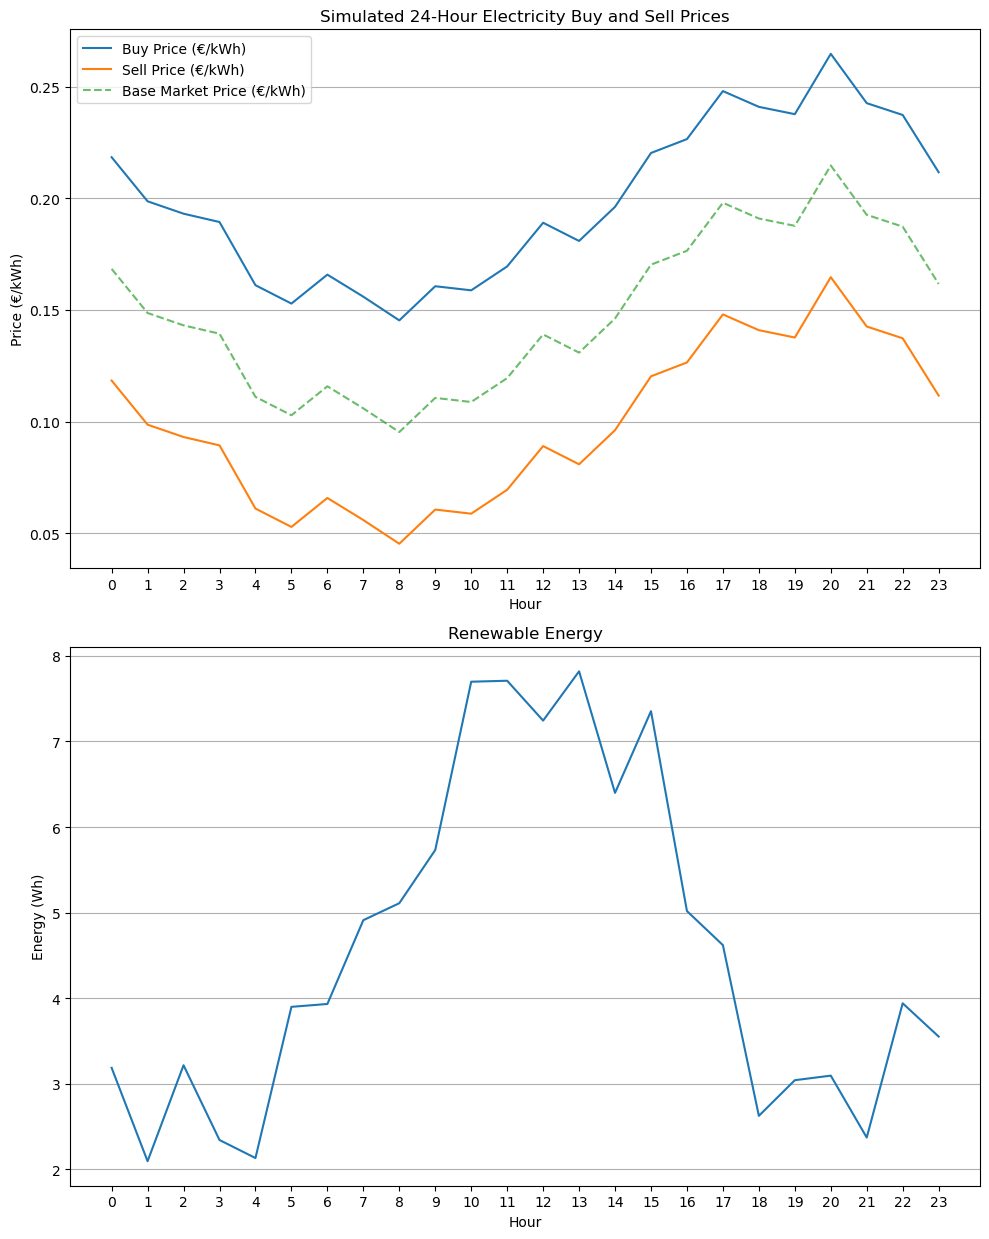

In [3]:
# Set seed for reproducibility
np.random.seed(42)

# === 1. Time Horizon ===
H = 24
horizon = 6
N=10
hours = np.arange(H)
base_price = 0.15
amplitude = 0.10
noise = np.random.normal(0, 0.01, size=H)

# Symmetric price
prices = base_price + amplitude * (
    np.sin((hours - 8) / 24 * 2 * np.pi) + np.sin((hours - 18) / 24 * 2 * np.pi)
) + noise
prices = np.clip(prices, 0.05, None)

# Add asymmetric buy/sell prices
margin = 0.05
c = prices + margin
p = prices - margin
p = np.clip(p, 0.01, None)  # Prevent negative prices


# === 3. Generate Renewable Energy ===
pv_gen = np.maximum(0, 5 * np.sin((hours - 6) * np.pi / 12))  # PV peaks at noon
wt_gen = 2 + np.random.rand(H) * 2  # Wind is random but consistent
q = (pv_gen + wt_gen)


# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 12.5))  # 1 row, 2 columns

# First subplot: Buy and Sell Prices
axs[0].plot(hours, c, label='Buy Price (€/kWh)')
axs[0].plot(hours, p, label='Sell Price (€/kWh)')
axs[0].plot(hours, prices, label='Base Market Price (€/kWh)', linestyle='--', alpha=0.7)
axs[0].set_title("Simulated 24-Hour Electricity Buy and Sell Prices")
axs[0].set_xlabel("Hour")
axs[0].set_ylabel("Price (€/kWh)")
axs[0].grid(axis='y')
axs[0].set_xticks(range(0, 24))
axs[0].legend()

# Second subplot: Renewable energy
axs[1].plot(np.arange(H), q)
axs[1].set_title("Renewable Energy")
axs[1].set_xlabel("Hour")
axs[1].set_ylabel("Energy (Wh)")
axs[1].grid(axis='y')
axs[1].set_xticks(range(0, 24))

plt.tight_layout()
plt.savefig("Environmental parameters", dpi=300)
plt.show()

In [8]:
# Parameters
N = 5       # Number of agents
c1 = 5
np.random.seed(42)
L_target = np.random.uniform(70, 90, size=N)
L_init = np.random.uniform(20, 60, size=N)

L_min = np.ones((N, H)) * 20
L_max = np.ones((N, H)) * 100

d_min = np.zeros((N, H))
d_max = np.ones((N, H)) * 10

f_min = np.zeros((N, H))
f_max = np.ones((N, H)) * 10

l_min = np.zeros((N, H))
l_max = np.ones((N, H)) * 10

m_min = np.zeros((N, H))
m_max = np.ones((N, H)) * 10

# Decision variables for each agent
x = [cp.Variable(5*H) for _ in range(N)]

constraints = []
objective = 0
cost_terms = []
penalty_terms = []

for n in range(N):
    d = x[n][:H]
    f = x[n][H:2*H]
    l = x[n][2*H:3*H]
    m = x[n][3*H:4*H]
    L = x[n][4*H:]

    constraints += [
        L >= L_min[n],
        L <= L_max[n],
        d >= d_min[n],
        d <= d_max[n],
        f >= f_min[n],
        f <= f_max[n],
        l >= l_min[n],
        l <= l_max[n],
        m >= m_min[n],
        m <= m_max[n]
    ]

    constraints += [
        L[0] == L_init[n] + l[0] - m[0]
    ]
    for h in range(1, H):
        constraints += [
            L[h] == L[h-1] + l[h] - m[h],
            cp.abs(l[h-1] - l[h]) <= 1,
            cp.abs(m[h-1] - m[h]) <= 1,
            cp.abs(d[h-1] - d[h]) <= 1,
            cp.abs(f[h-1] - f[h]) <= 1,
        ]

    cost_term = cp.sum(c @ d / q) - cp.sum(p @ f / q)
    penalty_term = (L[-1]-L_target[n])**2
    objective += c1*cost_term + penalty_term
    cost_terms.append(cost_term)
    penalty_terms.append(penalty_term)

#overall energy consumption
for h in range(H):
    constraints +=[q[h] == -cp.sum(x, axis=0)[:H][h] + cp.sum(x, axis=0)[H:2*H][h] + cp.sum(x, axis=0)[2*H:3*H][h] - cp.sum(x, axis=0)[3*H:4*H][h]]

# Solve the problem
prob = cp.Problem(cp.Minimize(objective), constraints)
prob.solve(solver="CVXOPT")

# Collect data for plotting
d_history = np.array([x[n][:H].value for n in range(N)])
f_history = np.array([x[n][H:2*H].value for n in range(N)])
l_history = np.array([x[n][2*H:3*H].value for n in range(N)])
m_history = np.array([x[n][3*H:4*H].value for n in range(N)])
L_history = np.array([x[n][4*H:].value for n in range(N)])

for n in range(N):
    print(f"Objective functions in Agent {n}: "
          f"Cost term: {cost_terms[n].value:.2f}, "
          f"Penalty term: {penalty_terms[n].value:.2f}")

print(f"overall objective: {objective.value}")

Objective functions in Agent 0: Cost term: 17.53, Penalty term: 6.44
Objective functions in Agent 1: Cost term: 17.53, Penalty term: 6.44
Objective functions in Agent 2: Cost term: 17.53, Penalty term: 6.44
Objective functions in Agent 3: Cost term: 17.53, Penalty term: 6.44
Objective functions in Agent 4: Cost term: 17.53, Penalty term: 6.44
overall objective: 470.4075822802143


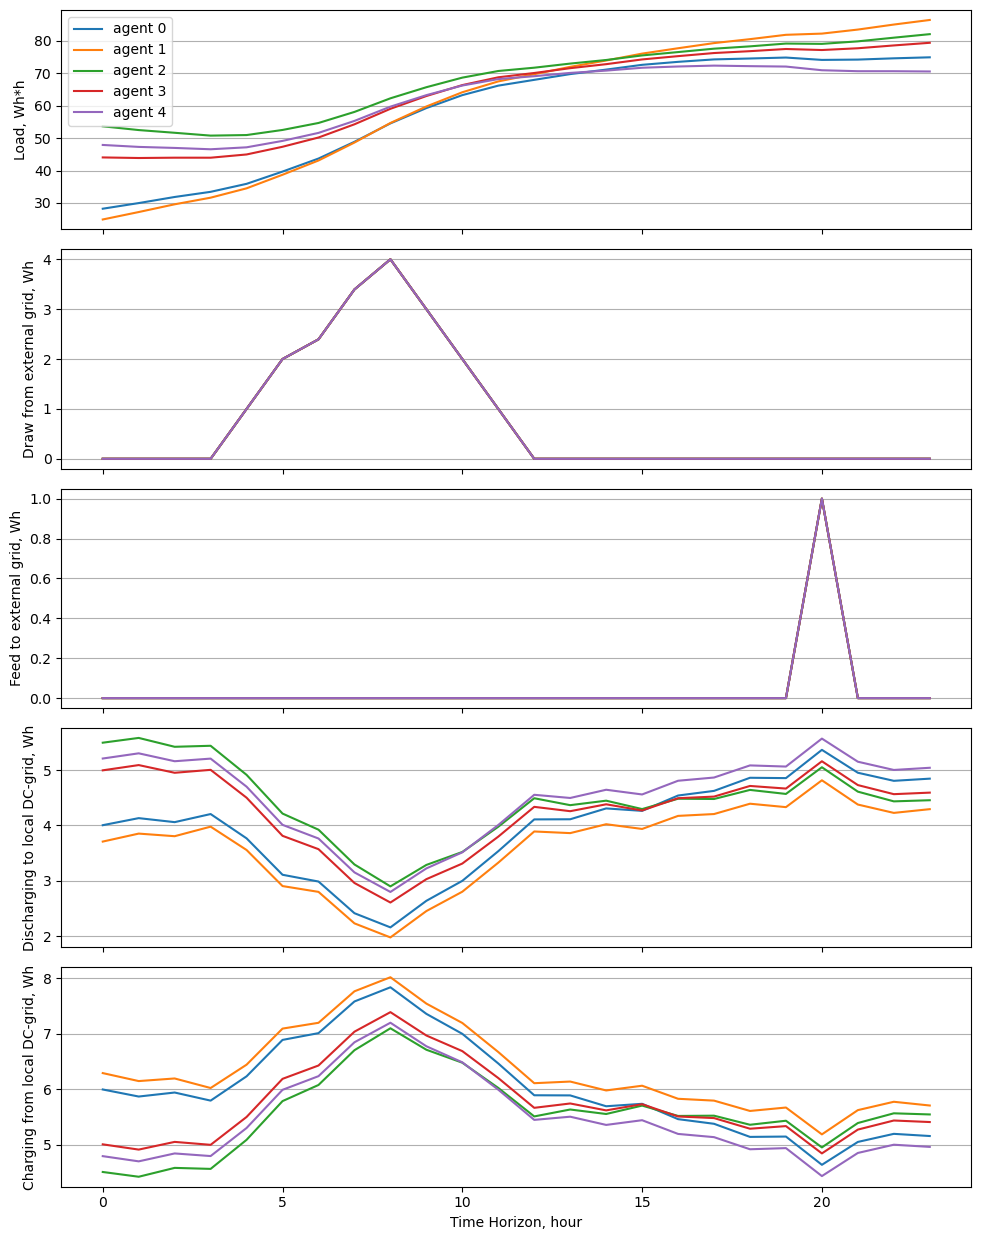

In [21]:
# Plotting
fig, axes = plt.subplots(5, 1, figsize=(10, 5*2.5), sharex=True)

for n in range(N):
    #axes[0].plot(np.full(H,L_target[n]))
    axes[0].plot(L_history[n], label =f'agent {n}')
    axes[0].grid(axis='y')
    axes[0].legend()
    axes[0].set_ylabel("Load, Wh*h")

for n in range(N):
    axes[1].plot(d_history[n])
    axes[1].grid(axis='y')
    axes[1].set_ylabel("Draw from external grid, Wh")

for n in range(N):
    axes[2].plot(f_history[n])
    axes[2].grid(axis='y')
    axes[2].set_ylabel("Feed to external grid, Wh")
    
for n in range(N):
    axes[3].plot(m_history[n])
    axes[3].grid(axis='y')
    axes[3].set_ylabel("Discharging to local DC-grid, Wh")
    
for n in range(N):
    axes[4].plot(l_history[n])
    axes[4].grid(axis='y')
    axes[4].set_ylabel("Charging from local DC-grid, Wh")
    

axes[-1].set_xlabel('Time Horizon, hour')
plt.tight_layout()
plt.savefig("Centralised framework", dpi=300)
plt.show()

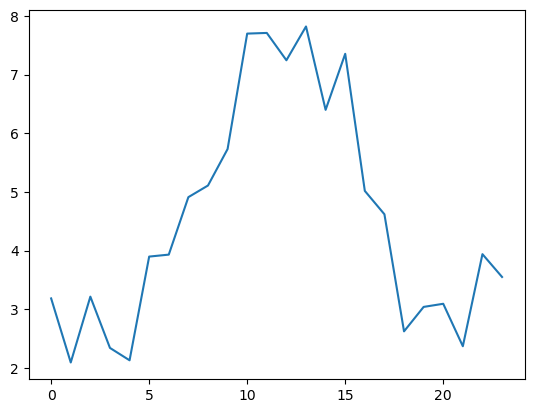

In [6]:
plt.plot(-np.sum(d_history,axis=0)+np.sum(f_history,axis=0)+np.sum(l_history,axis=0)-np.sum(m_history,axis=0))

In [58]:
N=5
for n in range(N):
    print(f"Error between target and real load of {1+n} agent is {100 * (L_target[n] - L_history[n][-1])/L_target[n]:.2f}%")

Error between target and real load of 1 agent is 3.55%
Error between target and real load of 2 agent is 3.03%
Error between target and real load of 3 agent is 3.28%
Error between target and real load of 4 agent is 3.12%
Error between target and real load of 5 agent is 2.84%


In [12]:
5*np.sum((c @ np.sum(d_history,axis=0) + p @ np.sum(f_history,axis=0))/q) + (L_target - L_history[:,-1]).T@(L_target - L_history[:,-1])

522.3457563245248